<a href="https://colab.research.google.com/github/emrecicekyurt/TensorFlowTutorialProjects/blob/main/Transfer_Learning_TF_FeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Downlaod the data and become one with it

In [13]:
# Get the data
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-06-28 17:03:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.128, 74.125.196.128, 74.125.134.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   193MB/s    in 0.8s    

2022-06-28 17:03:48 (193 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [14]:
# How many images in each folder
import os

# Walk through data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}") 

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 10 directori

### 2. Creating Data Loaders

We will use the ImageDataGenerator to load the images into batches

In [15]:
# Setting up data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size= BATCH_SIZE,
                                                          class_mode = "categorical")

print("Test images: ")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size= BATCH_SIZE,
                                                          class_mode = "categorical")


Training images: 
Found 750 images belonging to 10 classes.
Test images: 
Found 2500 images belonging to 10 classes.


### 3. Setting up Callbacks

Callbacks are extra functionality that you can add to your models to be performed during or after training.

* Tracking experiments with the **TensorBoard** callback
* Model checkpoint with the **ModelCheckPoint** Callback
* Stopping a model from training with the **EarlyStopping** callback


In [16]:
# Create TensorBoard callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiement_name):
  log_dir = dir_name +"/"+experiement_name+ "/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving Tensorboard log files to : {log_dir}")
  return tensorboard_callback

In [17]:
## Creating models using tensorflow hub 
## Lets compare following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [18]:
# Import dependencies
import tensorflow_hub as hub
from tensorflow.keras import layers

## 4. Creating Models

In [19]:
# Lets make a create model function from url

def create_model(model_url, num_classes = 10):
  """
  Takes  a TensorFlow hub url and creates a keras Sequential model with it 

  Args: 
    model_url : A TensorFlow Hub feature extraction url (str)
    num_classes : Number of output neurons in output layer default: 10 (int)

  Returns: 
    An uncompiled Keras Sequential model with model_url as feature extractor layer
    and Dense output layer witl num_classes neurons
  """

  # Download the pretrained 
  feature_exracter_layer = hub.KerasLayer(model_url,
                                          trainable = False, # freeze the already learned patterns
                                          name = "feature-extractor",
                                           input_shape = IMAGE_SHAPE+(3,)) # (224,224) -> (224,224,3)

  # Create the model

  model = tf.keras.Sequential([
                               feature_exracter_layer,
                               layers.Dense(num_classes, activation= "softmax", name = "output-layer")
  ])

  return model

In [20]:
# Create Resnet model 
resnet_model = create_model(resnet_url, 
                            num_classes= train_data_10_percent.num_classes)

In [21]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature-extractor (KerasLay  (None, 2048)             23564800  
 er)                                                             
                                                                 
 output-layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [22]:
# compile resnet model
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = "adam",
                     metrics = ["accuracy"])

In [24]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data_10_percent,
                                  validation_steps = len(test_data_10_percent),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiement_name="resnet50V2")],
                                  )

Saving Tensorboard log files to : tensorflow_hub/resnet50V2/20220628-173104
Epoch 1/5
24/24 [==============================] - 33s 786ms/step - loss: 1.9969 - accuracy: 0.3307 - val_loss: 1.2090 - val_accuracy: 0.6348
Epoch 2/5
24/24 [==============================] - 17s 710ms/step - loss: 0.9190 - accuracy: 0.7333 - val_loss: 0.8919 - val_accuracy: 0.7172
Epoch 3/5
24/24 [==============================] - 17s 709ms/step - loss: 0.6466 - accuracy: 0.8213 - val_loss: 0.7582 - val_accuracy: 0.7560
Epoch 4/5
24/24 [==============================] - 17s 710ms/step - loss: 0.4879 - accuracy: 0.8813 - val_loss: 0.7007 - val_accuracy: 0.7784
Epoch 5/5
24/24 [==============================] - 16s 705ms/step - loss: 0.3925 - accuracy: 0.9053 - val_loss: 0.6674 - val_accuracy: 0.7860


In [26]:
import matplotlib.pyplot as plt
# Plotting the curves separately to make them more clear

def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()  

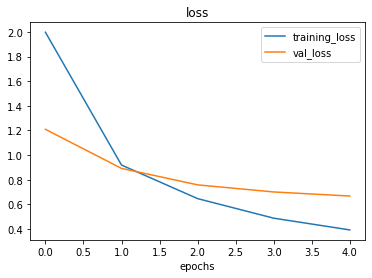

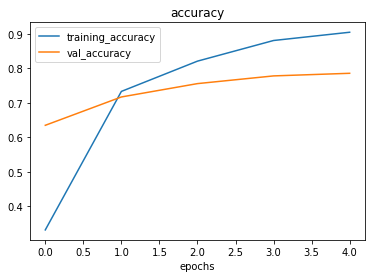

In [27]:
plot_loss_curves(resnet_history)

In [28]:
# Create efficientnet model 
efficientnet_model = create_model(efficientnet_url, 
                            num_classes= train_data_10_percent.num_classes)

In [30]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature-extractor (KerasLay  (None, 1280)             4049564   
 er)                                                             
                                                                 
 output-layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [31]:
# compile efficientnet model
efficientnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = "adam",
                     metrics = ["accuracy"])

In [32]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data_10_percent,
                                  validation_steps = len(test_data_10_percent),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiement_name="efficientnetB0")],
                                  )

Saving Tensorboard log files to : tensorflow_hub/efficientnetB0/20220628-182800
Epoch 1/5
24/24 [==============================] - 27s 762ms/step - loss: 1.8849 - accuracy: 0.3973 - val_loss: 1.3210 - val_accuracy: 0.7116
Epoch 2/5
24/24 [==============================] - 16s 680ms/step - loss: 1.0695 - accuracy: 0.7507 - val_loss: 0.8720 - val_accuracy: 0.8140
Epoch 3/5
24/24 [==============================] - 16s 672ms/step - loss: 0.7525 - accuracy: 0.8480 - val_loss: 0.7014 - val_accuracy: 0.8408
Epoch 4/5
24/24 [==============================] - 17s 710ms/step - loss: 0.6025 - accuracy: 0.8667 - val_loss: 0.6122 - val_accuracy: 0.8484
Epoch 5/5
24/24 [==============================] - 16s 681ms/step - loss: 0.5094 - accuracy: 0.9027 - val_loss: 0.5565 - val_accuracy: 0.8588


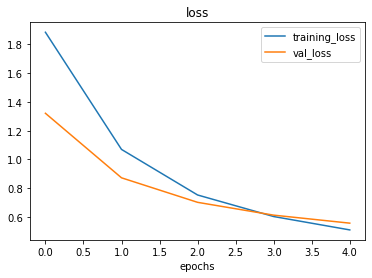

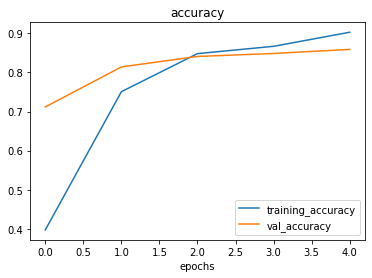

In [33]:
plot_loss_curves(efficientnet_history)

## 5. Comparing Model Results with TensorBoard

In [37]:
# Upload Tensorboard Dev Records 
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs ResNet50V2" \
--description "Comparing two different TF hub feature extraction model" \
--one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/SdqaFnazQFGymCNv5iobVw/

[2022-06-28T19:16:26] Started scanning logdir.
[2022-06-28T19:16:29] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.5 MB)
[2022-06-28T19:16:29] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/SdqaFnazQFGymCNv5iobVw/


Our TensorBoard experiments are uploaded to https://tensorboard.dev/experiment/6n4YRsQET5qiO6l3zQTAOQ/ publicly. If yo dont want to share your experiements with others dont upload them to the TensorBoard

In [38]:
!tensorboard dev list

https://tensorboard.dev/experiment/SdqaFnazQFGymCNv5iobVw/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF hub feature extraction model
	Id                   SdqaFnazQFGymCNv5iobVw
	Created              2022-06-28 19:16:26 (23 seconds ago)
	Updated              2022-06-28 19:16:28 (21 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5779172
https://tensorboard.dev/experiment/6n4YRsQET5qiO6l3zQTAOQ/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF hub feature extraction model
	Id                   6n4YRsQET5qiO6l3zQTAOQ
	Created              2022-06-28 19:08:17 (8 minutes ago)
	Updated              2022-06-28 19:08:20 (8 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5779172
Total: 2 experiment(s)
